In [219]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
from tqdm import tqdm
%matplotlib inline

# Read in borough park polygon

In [164]:
borough_park = gpd.read_file("../data/neighborhood_tabulation_areas/top_predictions/borough_park.shp")
borough_park.crs = {'init' :'epsg:4326'}

# Add approx 0.25 mile buffer around neighborhood
# So that jobs and workers on borders are included
borough_park_buffer = borough_park.copy()
borough_park_buffer['geometry'] = borough_park_buffer.buffer(0.004)

borough_park_polygon = borough_park.loc[0]['geometry']
borough_park_polygon_buffer = borough_park_buffer.loc[0]['geometry']

borough_park_buffer.to_file('../data/neighborhood_tabulation_areas/top_predictions/borough_park_buffer')

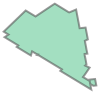

In [165]:
borough_park_polygon

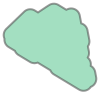

In [166]:
borough_park_polygon_buffer

# Read in borough park cleaned intersections

In [167]:
intersections = gpd.read_file("../data/neighborhood_tabulation_areas/top_predictions/borough_park_intersections/borough_park_intersections.shp")

In [168]:
intersections.crs = {'init' :'epsg:3857'}

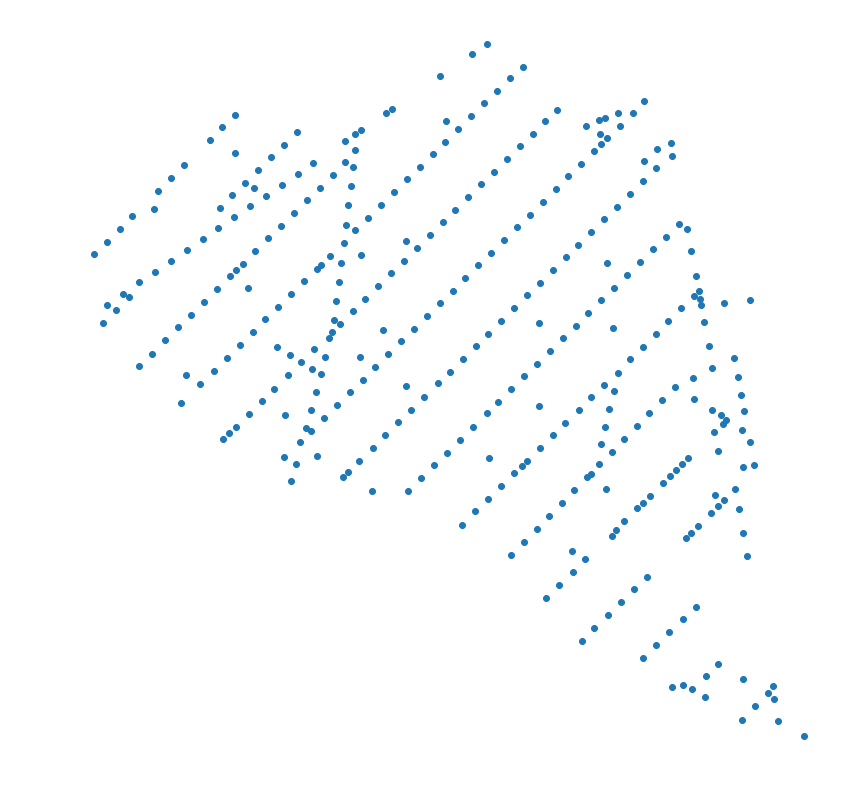

In [169]:
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
intersections.plot(ax=ax);

# Create 0.5 mile buffer around each intersection

In [170]:
# 800 meter buffer = approx 0.5 miles
intersections_buffer = intersections.copy()
intersections_buffer['geometry'] = intersections_buffer.buffer(800)

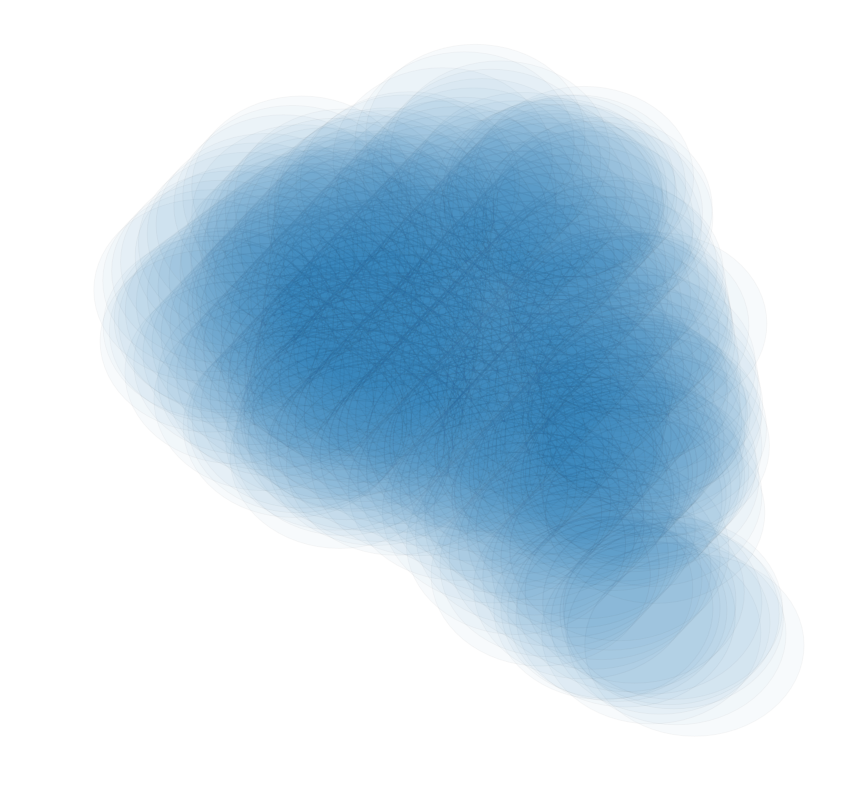

In [171]:
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
intersections_buffer.plot(ax=ax, alpha=0.03, edgecolor='black');

# Read in jobs

In [172]:
df = pd.read_csv("../data/origin_destination_employment/LODES_NYC.csv")

In [173]:
jobs = df[['dest_lat', 'dest_lon']]
jobs.columns = ['latitude', 'longitude']
geometry = [Point(xy) for xy in zip(jobs.longitude, jobs.latitude)]
crs = {'init': 'epsg:4326'}
jobs = gpd.GeoDataFrame(jobs, crs=crs, geometry=geometry)

In [174]:
jobs.head()

,latitude,longitude,geometry
0,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
1,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
2,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
3,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
4,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)


In [175]:
%%time

# clip jobs to include only those within a buffer of Borough Park
borough_park_jobs = gpd.sjoin(jobs, borough_park_buffer, how="inner", op='intersects')

CPU times: user 2min 11s, sys: 1.27 s, total: 2min 13s
Wall time: 2min 13s


In [176]:
%%time
# reproject to 3857 so we can use meters to set radius later
borough_park_jobs_3857 = borough_park_jobs.to_crs({'init': 'epsg:3857'})
del borough_park_jobs_3857['index_right']

CPU times: user 2.02 s, sys: 19.2 ms, total: 2.04 s
Wall time: 2.05 s


In [177]:
borough_park_jobs_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
314990,40.645213,-73.997657,POINT (-8237381.463739469 4960150.611691428),BK88,Borough Park,Brooklyn,2010,106357,0
314991,40.645213,-73.997657,POINT (-8237381.463739469 4960150.611691428),BK88,Borough Park,Brooklyn,2010,106357,0
314992,40.645213,-73.997657,POINT (-8237381.463739469 4960150.611691428),BK88,Borough Park,Brooklyn,2010,106357,0
314993,40.645213,-73.997657,POINT (-8237381.463739469 4960150.611691428),BK88,Borough Park,Brooklyn,2010,106357,0
314994,40.645213,-73.997657,POINT (-8237381.463739469 4960150.611691428),BK88,Borough Park,Brooklyn,2010,106357,0


In [178]:
from scipy import ndimage

In [179]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


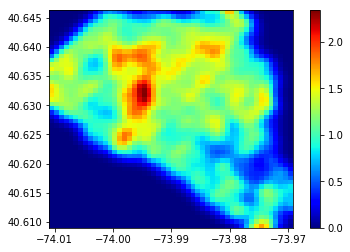

In [180]:
heatmap(borough_park_jobs, bins=50, smoothing=1.5)

# Read in population

In [181]:
population = df[['origin_lat', 'origin_lon']]
population.columns = ['latitude', 'longitude']

population = df[['origin_lat', 'origin_lon']]
population.columns = ['latitude', 'longitude']
geometry = [Point(xy) for xy in zip(population.longitude, population.latitude)]
crs = {'init': 'epsg:4326'}
population = gpd.GeoDataFrame(population, crs=crs, geometry=geometry)

In [182]:
%%time

# clip population to include only those within borough park
borough_park_population = gpd.sjoin(population, borough_park_buffer, how="inner", op='intersects')

CPU times: user 1min 23s, sys: 828 ms, total: 1min 24s
Wall time: 1min 24s


In [183]:
# reproject to 3857 so we can use meters to set radius later
%time
borough_park_population_3857 = borough_park_population.to_crs({'init': 'epsg:3857'})
del borough_park_population_3857['index_right']

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


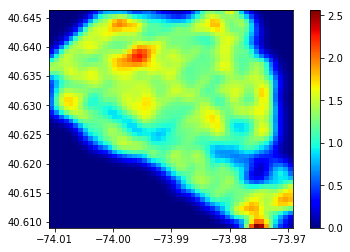

In [184]:
heatmap(borough_park_population, bins=50, smoothing=1.5)

# Build a dict of stations within 0.1 miles of eachother

In [211]:
# 80 meters = approx 0.05 miles
# 160 meters = approx 0.1 miles

min_meters_between_stations = 300
intersections_buffer_01 = intersections.copy()
intersections_buffer_01['geometry'] = intersections_buffer_01.buffer(min_meters_between_stations)

nearby_nodes = {}
for i in tqdm(intersections.index):
    buffer = intersections_buffer_01.loc[[i]]
    within_buffer = gpd.sjoin(intersections, buffer, how='inner', op='intersects')
    ids = list(within_buffer['id_left'])
    nearby_nodes[i] = ids

100%|██████████| 361/361 [00:09<00:00, 38.94it/s]


In [212]:
nearby_nodes[1]

[0, 1, 2, 3, 4, 6, 11]

# Create nearby jobs dict

In [187]:
jobs = {}
for i in tqdm(intersections.index):
    buffer = intersections_buffer.loc[[i]]
    within_buffer = gpd.sjoin(borough_park_jobs_3857, buffer, how='inner', op='intersects')
    num_jobs = len(within_buffer)
    jobs[i] = num_jobs

100%|██████████| 361/361 [12:31<00:00,  2.08s/it]


In [188]:
jobs[1]

2961

# Create nearby people dict

In [189]:
workers = {}
for i in tqdm(intersections.index):
    buffer = intersections_buffer.loc[[i]]
    within_buffer = gpd.sjoin(borough_park_population_3857, buffer, how='inner', op='intersects')
    num_workers = len(within_buffer)
    workers[i] = num_workers

100%|██████████| 361/361 [10:58<00:00,  1.82s/it]


In [190]:
workers[1]

5921

# Create jobs + workers dict

In [191]:
jobs_and_workers = {}
for i in tqdm(intersections.index):
    num_jobs = jobs[i]
    num_workers = workers[i]
    jobs_and_workers[i] = num_jobs + num_workers

100%|██████████| 361/361 [00:00<00:00, 702618.91it/s]


In [192]:
jobs_and_workers[1]

8882

# Algorithm

Goal: find the set of $n$ nodes in $V$ that maximize the total number of jobs and workers within 0.25 miles of each node such that no two nodes are within 0.1 miles of each other.

Graph $G = (V, E)$

$J_i$ = # of jobs within 0.5 miles of node $i$

$W_i$ = # of workers within 0.5 miles of node $i$

$D_{ij}$ = distance from node $i$ to node $j$

For every node $i$ in $V$,

Initialize a list of chosen stations $C$. Add $i$ to $C$.

Initialize a list of nodes to explore $X$. 

For every node $j$ in $V$,

add $j$ to $X$ if $D_{ij}$ > 0.1 miles.

Find the node in $X$ that maximize total number of jobs and workers.

Remove this top node from $X$. Also remove any nearby nodes to this top node from $X$.

In [213]:
nearby_nodes[0]

[0, 1, 4]

In [300]:
# List of every node
nodes = list(intersections.index)

# Limit to 20 nodes
limit = 25

# Store results in a dict
results = {}

# For every node
for i in nodes:
    
    # Initialize a list of chosen stations
    chosen = [i]
    
    # Initialize nodes to explore
    to_be_explored = jobs_and_workers.copy()

    # Remove any nearby node from nodes to explore
    near_citibike = nearby_nodes[i]
    for n in near_citibike:
        to_be_explored.pop(n, None)
    
    for j in range(limit-1):
        
        # Find the node with maximum jobs and workers
        argmax = max(to_be_explored, key=to_be_explored.get)
        
        # Add that node to chosen list
        chosen.append(argmax)
        
        # Remove that node from nodes to explore
        to_be_explored.pop(argmax, None)
        
        # Remote nearby nodes from nodes to explore
        near_chosen = nearby_nodes[argmax]
        for n in near_chosen:
            to_be_explored.pop(n, None)
        
    results[i] = chosen

# Which result has the maximum total jobs and workers?
values = {}
for i in results.keys():
    total = 0
    for n in results[i]:
        total += jobs_and_workers[n]
    values[i] = total

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


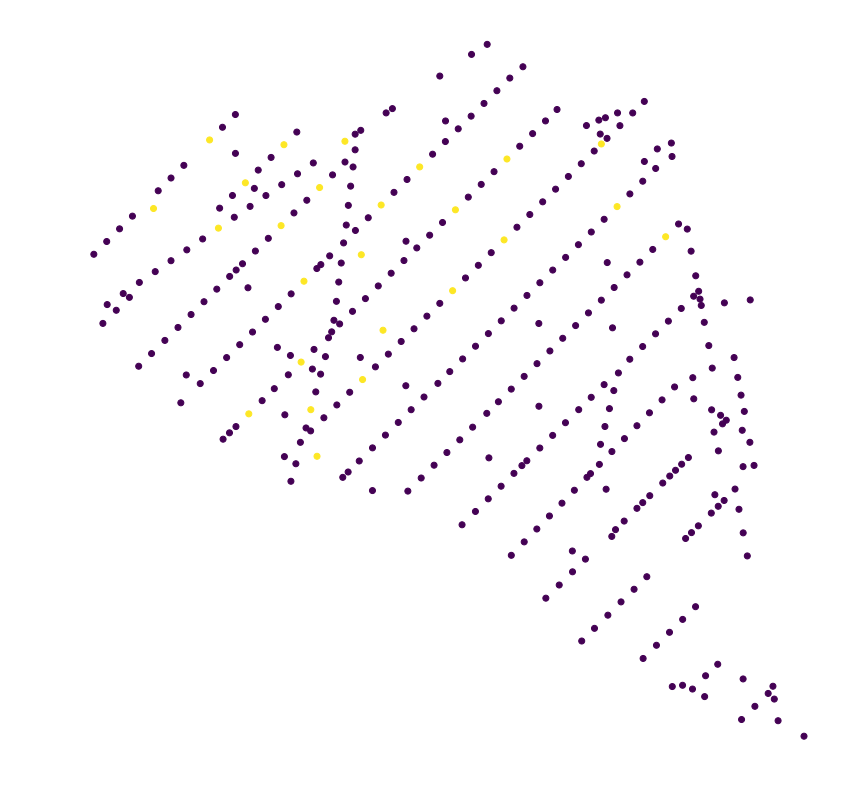

In [301]:
intersections_chosen = intersections.copy()
intersections_chosen['query'] = 0
for i in results[max(values, key=values.get)]:
    intersections_chosen.ix[i, 'query'] = 1
    
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
intersections_chosen.plot(ax=ax, column='query')

intersections_chosen_4326 = intersections_chosen.to_crs({'init': 'epsg:4326'})
intersections_chosen_4326.to_file("../assets/chosen_intersections/{}".format(limit))

In [239]:
#intersections_chosen_4326.to_file("../data/intersections_chosen")

# Read in subway volumes

In [96]:
september_subway = pd.read_csv("../data/subway_turnstiles/september2017_subway_volumes.csv")

In [97]:
crs = {'init': 'epsg:4326'}
geom = [Point(xy) for xy in zip(september_subway['longitude'], september_subway['latitude'])]
september_subway = gpd.GeoDataFrame(september_subway, geometry=geom, crs=crs)

In [98]:
september_subway.head()

,Unnamed: 0,Station,yearMonth,Exits,Entries,Total_Volume,station_name,latitude,longitude,geometry
0,0,1 AV,201709,412637,388384,801021,1 AV,40.768655,-73.958426,POINT (-73.95842590000001 40.7686549)
1,1,103 ST,201709,391889,613681,1005570,103 ST,40.796088,-73.961453,POINT (-73.96145260000002 40.7960878)
2,2,103 ST-CORONA,201709,3437856,11942506,15380362,103 ST-CORONA,40.749779,-73.862646,POINT (-73.86264609999998 40.7497795)
3,3,104 ST,201709,13628,63030,76658,104 ST,40.681333,-73.838846,POINT (-73.83884570000001 40.6813328)
4,4,110 ST,201709,160893,224511,385404,110 ST,40.798483,-73.952613,POINT (-73.95261309999999 40.7984831)


In [99]:
september_subway.shape

(378, 10)

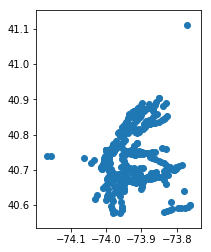

In [100]:
september_subway.plot()

In [101]:
september_subway.crs

{'init': 'epsg:4326'}

In [122]:
borough_park_buffer = borough_park.copy()
borough_park_buffer['geometry'] = borough_park_buffer['geometry'].buffer(0.01)

In [123]:
# clip population to include only those within borough park
borough_park_september_subway = gpd.sjoin(september_subway, borough_park_buffer, how="inner", op='intersects')

In [124]:
borough_park_september_subway.crs

{'init': 'epsg:4326'}

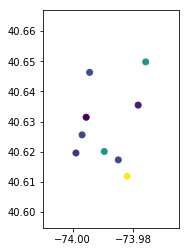

In [125]:
borough_park_september_subway.plot(column='Total_Volume')

In [127]:
borough_park_september_subway.to_file("../data/subway_turnstiles/september2017_subway_volumes_borough_park.csv")

In [135]:
borough_park_september_subway_3857 = borough_park_september_subway.to_crs({'init': 'epsg:3857'})

# For every intersection, calculate nearby jobs, population and subway volume

In [169]:
del borough_park_jobs_3857['index_right']
borough_park_jobs_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
323804,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323805,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323806,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323807,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323808,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0


In [170]:
del borough_park_population_3857['index_right']
borough_park_population_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
719,40.636461,-73.981659,POINT (-8235600.596789655 4958866.73823975),BK88,Borough Park,Brooklyn,2010,106357,0
1632,40.639891,-73.988850,POINT (-8236401.106379899 4959369.851633735),BK88,Borough Park,Brooklyn,2010,106357,0
1933,40.633034,-74.003162,POINT (-8237994.322064081 4958363.988068293),BK88,Borough Park,Brooklyn,2010,106357,0
1936,40.634640,-73.990726,POINT (-8236609.919480728 4958599.598114852),BK88,Borough Park,Brooklyn,2010,106357,0
2705,40.632563,-73.985759,POINT (-8236057.062361654 4958294.987170252),BK88,Borough Park,Brooklyn,2010,106357,0


In [171]:
del borough_park_september_subway_3857['index_right']
borough_park_september_subway_3857.head()

,Unnamed: 0,Station,yearMonth,Exits,Entries,Total_Volume,station_name,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
31,31,18 AV,201709,102161,275497,377658,18 AV,40.620091,-73.989482,POINT (-8236471.493693925 4956465.643189163),BK88,Borough Park,Brooklyn,2010,106357,0
39,39,20 AV,201709,28004,159106,187110,20 AV,40.617304,-73.984833,POINT (-8235953.913721482 4956056.946106019),BK88,Borough Park,Brooklyn,2010,106357,0
82,82,55 ST,201709,16548,37654,54202,55 ST,40.631435,-73.995476,POINT (-8237138.709325896 4958129.469140499),BK88,Borough Park,Brooklyn,2010,106357,0
96,96,71 ST,201709,33304,116680,149984,71 ST,40.619589,-73.998864,POINT (-8237515.859760704 4956392.021313072),BK88,Borough Park,Brooklyn,2010,106357,0
113,113,9 AV,201709,93030,111850,204880,9 AV,40.646292,-73.994324,POINT (-8237010.469272499 4960308.974836171),BK88,Borough Park,Brooklyn,2010,106357,0


In [172]:
intersections.head()

,id,geometry
0,0,POINT (-8234747.733642889 4955578.345774663)
1,1,POINT (-8234878.478384824 4955678.563065642)
2,2,POINT (-8235062.712142089 4955686.33530107)
3,3,POINT (-8234995.47516965 4955771.68365043)
4,4,POINT (-8234897.614205291 4955818.654889079)


In [208]:
# 800 meter buffer = approx 0.5 miles
intersections_buffer = intersections.copy()
intersections_buffer['geometry'] = intersections_buffer.buffer(800)

In [209]:
ids = []
jobs = []
populations = []
subway_volumes = []

for i in tqdm(intersections_buffer.index):
    
    ids.append(i)
    
    node = intersections_buffer.loc[[i]]
    
    # count jobs
    job_join = gpd.sjoin(borough_park_jobs_3857, node, how='inner', op='intersects')
    job_count = len(job_join)
    jobs.append(job_count)
    
    # count people
    population_join = gpd.sjoin(borough_park_population_3857, node, how='inner', op='intersects')
    population_count = len(population_join)
    populations.append(population_count)
    
    # sum subway volumes
    subway_join = gpd.sjoin(borough_park_september_subway_3857, node, how='inner', op='intersects')
    subway_sum = subway_join['Total_Volume'].sum()
    subway_volumes.append(subway_sum)

100%|██████████| 361/361 [12:23<00:00,  2.06s/it]


In [393]:
results = pd.DataFrame()
results['id'] = ids
results['jobs'] = jobs
results['population'] = populations
#results['subway_volume'] = subway_volumes
results['total'] = results['jobs'] + results['population'] #+ results['subway_volume'] / 300

In [394]:
results.sort_values('total', ascending=False).head(10)

,id,jobs,population,total
277,277,14199,6219,20418
351,351,13677,6649,20326
261,261,13666,6264,19930
345,345,13648,6227,19875
276,276,13505,6325,19830
249,249,13623,6014,19637
231,231,13503,5940,19443
349,349,13561,5803,19364
216,216,13523,5791,19314
253,253,13286,6011,19297


In [420]:
top_ids = list(results.sort_values('total', ascending=False).head(20)['id'])

In [437]:
intersections_test = intersections.copy()
intersections_test['query'] = 0
for i in top_ids:
    intersections_test.ix[i, 'query'] = 1

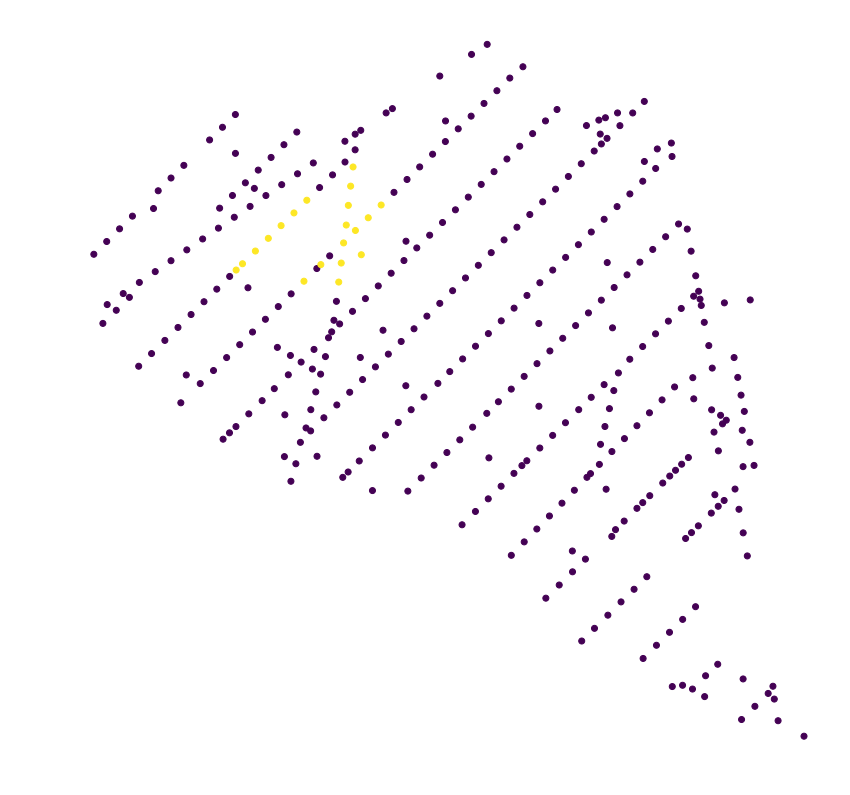

In [439]:
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
intersections_test.plot(ax=ax, column='query')

In [611]:
results = {}
count = 0
limit = 3
for i in tqdm(list(intersections.index)):
    nodes_that_get_citibike = [i]
    nodes_that_are_near_citibike = nearby_nodes[i]
    nodes_to_be_explored = [i for i in list(intersections.index) if i not in nodes_that_are_near_citibike]
    print(nodes_that_are_near_citibike)
    
    street_activity = nearby_jobs_and_workers.copy()
    
    while count <= limit:
    
        for j in nodes_to_be_explored:

            for n in nodes_that_are_near_citibike:
                street_activity.pop(n, None)

            # find node that maximizes nearby jobs + workers
            argmax = max(street_activity, key=street_activity.get)
            print(argmax)

            # give that node a citibike
            nodes_that_get_citibike.append(argmax)

            # add nearby nodes to list
            for n in nearby_nodes[argmax]:
                nodes_that_are_near_citibike.append(argmax)

        count += 1
    
    results[i] = nodes_that_get_citibike

100%|██████████| 361/361 [00:00<00:00, 9842.39it/s]

[0, 1, 277, 277, 277, 277, 277, 277, 277, 277, 351, 351, 351, 351, 351, 351, 351, 351, 261, 261, 261, 261, 261, 261, 261, 261, 345, 345, 345, 345, 345, 345, 345, 345, 345, 276, 276, 276, 276, 276, 276, 276, 276, 276, 249, 249, 249, 249, 249, 249, 249, 231, 231, 231, 231, 231, 231, 231, 349, 349, 349, 349, 349, 349, 349, 216, 216, 216, 216, 216, 216, 253, 253, 253, 253, 253, 253, 253, 253, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 211, 211, 211, 211, 211, 211, 211, 211, 211, 259, 259, 259, 259, 259, 259, 259, 259, 230, 230, 230, 230, 230, 230, 230, 230, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 245, 245, 245, 245, 245, 245, 245, 245, 245, 348, 348, 348, 348, 348, 348, 348, 348, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 271, 271, 271, 271, 271, 227

In [607]:
results

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13],
 14: [14],
 15: [15],
 16: [16],
 17: [17],
 18: [18],
 19: [19],
 20: [20],
 21: [21],
 22: [22],
 23: [23],
 24: [24],
 25: [25],
 26: [26],
 27: [27],
 28: [28],
 29: [29],
 30: [30],
 31: [31],
 32: [32],
 33: [33],
 34: [34],
 35: [35],
 36: [36],
 37: [37],
 38: [38],
 39: [39],
 40: [40],
 41: [41],
 42: [42],
 43: [43],
 44: [44],
 45: [45],
 46: [46],
 47: [47],
 48: [48],
 49: [49],
 50: [50],
 51: [51],
 52: [52],
 53: [53],
 54: [54],
 55: [55],
 56: [56],
 57: [57],
 58: [58],
 59: [59],
 60: [60],
 61: [61],
 62: [62],
 63: [63],
 64: [64],
 65: [65],
 66: [66],
 67: [67],
 68: [68],
 69: [69],
 70: [70],
 71: [71],
 72: [72],
 73: [73],
 74: [74],
 75: [75],
 76: [76],
 77: [77],
 78: [78],
 79: [79],
 80: [80],
 81: [81],
 82: [82],
 83: [83],
 84: [84],
 85: [85],
 86: [86],
 87: [87],
 88: [88],
 89: [89],
 90: [90],
 91: [91],
 92: [92

In [604]:
max(nearby_jobs_and_workers, key=nearby_jobs_and_workers.get)

277

In [601]:
nearby_jobs_and_workers[0]

1614

In [597]:
max(nearby_jobs_and_workers, key=nearby_jobs_and_workers.get)

277

In [598]:
nodes_to_be_explored

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 148,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,


In [581]:
list(intersections.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
results = {}
for i in tqdm(intersections.index):
    i_list = []
    j_list = []
    J_j_list = []
    W_j_list = []
    A_j_list = []
    for j in tqdm(intersections.index):
        if j not in nearby_nodes[i]:
            J_j = nearby_jobs[j]
            W_j = nearby_workers[j]
            A_j = J_j + W_j
            i_list.append(i)
            j_list.append(j)
            J_j_list.append(J_j)
            W_j_list.append(W_j)
            A_j_list.append(A_j)
    df = pd.DataFrame()
    df['i'] = i_list
    df['j'] = j_list
    df['num_jobs'] = J_j_list

In [560]:
intersections.loc[[0]]

,id,geometry
index_left,,
0,0,POINT (-8234747.733642889 4955578.345774663)


In [565]:
borough_park_jobs_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
index_left,,,,,,,,,
323804,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323805,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323806,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323807,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323808,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0


In [558]:
for i in intersections.index:
    node_i = intersections.loc[[i]]
    jobs_i = len()
    for j in intersections.index:
        node_j = intersections.loc[[j]]
        

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359


212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127

KeyboardInterrupt: 

In [514]:
intersections

,id,geometry
0,0,POINT (-8234747.733642889 4955578.345774663)
1,1,POINT (-8234878.478384824 4955678.563065642)
2,2,POINT (-8235062.712142089 4955686.33530107)
3,3,POINT (-8234995.47516965 4955771.68365043)
4,4,POINT (-8234897.614205291 4955818.654889079)
5,5,POINT (-8235248.860594594 4955834.654197866)
6,6,POINT (-8234928.483100091 4955855.111647257)
7,7,POINT (-8235412.021572251 4955899.678238649)
8,8,POINT (-8235360.202349284 4955907.934596862)
9,9,POINT (-8235054.862509785 4955948.901822392)


In [440]:
intersections_test

,id,geometry,query
0,0,POINT (-8234747.733642889 4955578.345774663),0
1,1,POINT (-8234878.478384824 4955678.563065642),0
2,2,POINT (-8235062.712142089 4955686.33530107),0
3,3,POINT (-8234995.47516965 4955771.68365043),0
4,4,POINT (-8234897.614205291 4955818.654889079),0
5,5,POINT (-8235248.860594594 4955834.654197866),0
6,6,POINT (-8234928.483100091 4955855.111647257),0
7,7,POINT (-8235412.021572251 4955899.678238649),0
8,8,POINT (-8235360.202349284 4955907.934596862),0
9,9,POINT (-8235054.862509785 4955948.901822392),0


In [432]:
intersections

,id,geometry
0,0,POINT (-8234747.733642889 4955578.345774663)
1,1,POINT (-8234878.478384824 4955678.563065642)
2,2,POINT (-8235062.712142089 4955686.33530107)
3,3,POINT (-8234995.47516965 4955771.68365043)
4,4,POINT (-8234897.614205291 4955818.654889079)
5,5,POINT (-8235248.860594594 4955834.654197866)
6,6,POINT (-8234928.483100091 4955855.111647257)
7,7,POINT (-8235412.021572251 4955899.678238649)
8,8,POINT (-8235360.202349284 4955907.934596862)
9,9,POINT (-8235054.862509785 4955948.901822392)


In [433]:
import collections

def max_sum_separated_by_k(iterable, k):
    best = collections.deque([0]*(k+1), k+1)
    for item in iterable:
        best.appendleft(max(item + best[-1], best[0]))
    return best[0]

In [434]:
max_sum_separated_by_k()

TypeError: max_sum_separated_by_k() missing 2 required positional arguments: 'iterable' and 'k'

# Algorithm

Goal: Find the set of $n$ nodes that maximizes the sum of population $P_i$ and jobs $J_i$ that exist within 0.5 miles from node $i$ such that no two nodes are adjacent.

Download the street network for a polygon.

In [454]:
import geopandas as gpd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

In [455]:
def getStreetsByPolygon(polygon, mode, node_color='#66ccff', node_size=30, node_zorder=2, node_edgecolor='k'):
    G = ox.graph_from_polygon(polygon, network_type=mode)
    G = ox.project_graph(G, to_crs={'init': 'epsg:3857'})
    stats_ = ox.basic_stats(G)
    fig, ax = ox.plot_graph(G, show=True, save=False,fig_height=20, node_color=node_color, node_size=node_size, 
                            node_zorder=node_zorder, node_edgecolor=node_edgecolor)
    return G, stats_

In [456]:
borough_park = gpd.read_file('../data/neighborhood_tabulation_areas/top_predictions/borough_park.shp')

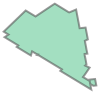

In [457]:
polygon = borough_park.loc[0]['geometry']
polygon

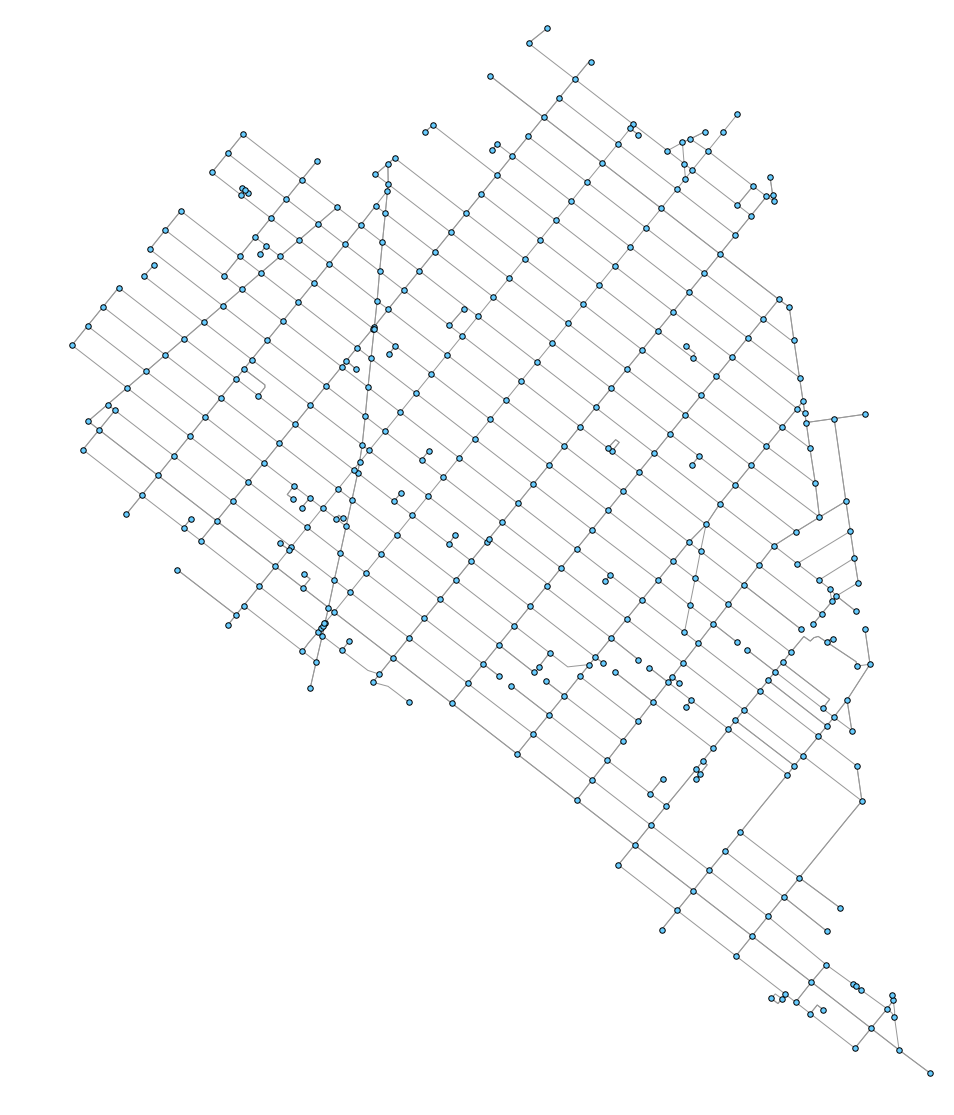

In [458]:
streets, stats = getStreetsByPolygon(polygon, mode='bike');

Build a neighbors dict.

In [506]:
neighbors = {}
for node in list(streets.nodes()):
    neighb = list(streets.neighbors(node))
    neighbors[node] = neighb

In [507]:
neighbors[42460215]

[42460214, 42460216, 42510218]

Build a number of neighbors dict.

In [509]:
number_of_neighbors = {}
for node in list(streets.nodes()):
    num = len(list(streets.neighbors(node)))
    number_of_neighbors[node] = num

In [510]:
number_of_neighbors[42460215]

3

In [512]:
len(intersections)

361

In [513]:
len(streets.nodes())

425

In [511]:
for node in list(streets.nodes()):
    if number_of_neighbors[node] == 1:
        print(node)

42460214
42460278
42460870
42460876
42460896
42466801
42466836
42468167
42468319
42472453
42472994
42473028
42473070
42473438
42473455
42473461
42480496
42484247
42484271
42484308
42486036
42486101
42486131
42488102
42488113
42488540
42495239
42496904
42497265
42501973
42515317
42515364
42517387
42517396
42521574
42524062
42536562
42536574
42538812
2441063443
2513522353
2847312857
2847312867
2847312868
2847313026
3291686131
4359063907
4359367605
4975920246
5488475457
5488475472
5488475473
5488527328
5488527331
5488527333
5488527335
5488527337
5488527339
5488527347
5488527349
5488559820
5488560124
5488560126
5488560129
5488560132
5488560134
5488618919
5488619521
5488619522
5488627069
5488627074
5488627075
5488627078
5488665298
5488665300
5488665306
5488740456
5488740458
5488740462
5488802844
5488802851
5488802864
5488802871


In [499]:
jobs_dict = {}
for i in list(streets.nodes()):
    
    # Exclude dead ends
    if number_of_edges[i] == 2:
        
        print(i)
    
    # get jobs within 0.5 miles
    #job_join = gpd.sjoin(borough_park_jobs_3857, i, how='inner', op='intersects')
    #job_count = len(job_join)
    #job_dict[i] = job_count
    
    # get people within 0.5 miles
    
    # street activity = jobs + people

42460214
42460278
42460870
42460876
42466836
42468167
42468319
42472453
42472994
42473070
42480496
42486101
42486131
42488540
42495239
42496904
42497265
42501973
42515317
42517387
42517396
42521574
42524062
42536562
42536574
42538812
2441063443
2513522353
2847312857
2847312867
2847312868
2847313026
3291686131
4359367605
4975920246
5488475457
5488475472
5488475473
5488527328
5488527331
5488527333
5488527335
5488527337
5488527339
5488527347
5488527349
5488560124
5488560126
5488560129
5488560132
5488560134
5488618919
5488619521
5488627069
5488627075
5488627078
5488665298
5488665300
5488665306
5488740456
5488740458
5488740462
5488802844
5488802851
5488802864


For every node $i$ in $G$, for every node $j$ in $G$:
        
if $j$ not in adjacency_list $A_i$:

calculate the sum of jobs $J_j$ + people $P_j$l = street activity $S_j$ 

create a table $T$ where $T_ij$ = $S_i$ + $S_j$

Create a variable to store the hightst Sum($T_ij$)

Sort $T_ij$ by highest total value and keep track of the $n$ top ranked rows from $T_ij$ and 



Keep track of the maximum table $T_ij$ for every node $i$.

The node with the biggest total volume Table wins!




In [490]:
intersections_buffer

,id,geometry
0,0,POLYGON ((-8233947.733642889 4955578.345774663...
1,1,POLYGON ((-8234078.478384824 4955678.563065642...
2,2,"POLYGON ((-8234262.712142089 4955686.33530107,..."
3,3,"POLYGON ((-8234195.47516965 4955771.68365043, ..."
4,4,POLYGON ((-8234097.614205291 4955818.654889079...
5,5,POLYGON ((-8234448.860594594 4955834.654197866...
6,6,POLYGON ((-8234128.483100091 4955855.111647257...
7,7,POLYGON ((-8234612.021572251 4955899.678238649...
8,8,POLYGON ((-8234560.202349284 4955907.934596862...
9,9,POLYGON ((-8234254.862509785 4955948.901822392...


In [485]:
for i in streets.nodes():
    
    print(i)
    
    

42460214
42460215
42460216
42460217
42460218
42460220
42460221
42460222
42460223
42460224
42460225
42460226
42460227
42460228
42460229
42460231
42460232
42460233
42460234
42460235
42460236
42460239
42460243
42460247
42460255
42460263
42460278
42460870
42460872
42460876
42460886
42460893
42460894
42460896
42460898
42460901
42460906
42460911
42460925
42460934
42460936
42460941
42460944
42460948
42460951
42460956
42460963
42464653
42464655
42466801
42466804
42466807
42466810
42466812
42466815
42466818
42466821
42466826
42466831
42466834
42466836
42468096
42468099
42468102
42468108
42468111
42468114
42468117
42468118
42468120
42468128
42468132
42468137
42468139
42468144
42468150
42468161
42468167
42468319
42468323
42468943
42468947
42468950
42472453
42472994
42472998
42473002
42473006
42473028
42473031
42473035
42473043
42473045
42473049
42473054
42473057
42473060
42473065
42473070
42473438
42473442
42473452
42473455
42473461
42473465
42473469
42473476
42477626
42477630
42477632
42477636
4